# **Libraries & path management**

> ## Import Libraries

In [1]:
!pip3 install ipdb
!pip3 install tqdm

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import cv2
from pathlib import Path
import numpy as np

from tqdm import tqdm
import os
from PIL import Image

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

from sklearn.feature_selection import RFECV, RFE
from sklearn.model_selection import StratifiedKFold
from sklearn import svm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Function
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, SubsetRandomSampler
from torch.cuda.amp import GradScaler, autocast
import torch.nn.functional as F

import ipdb
import time
import copy
import pdb
import itertools
from scipy.spatial.distance import cdist

import argparse

plt.ion()   # interactive mode
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
seed = 42

> ## Define Path

In [3]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [4]:
assesment_dir = "3.6"

data_path = Path('gdrive/My Drive/IDS_research/AWID2')

str_toimg_path = 'gdrive/My Drive/IDS_research/config'+assesment_dir+'/toimages'
toimg_path = Path(str_toimg_path)

str_models_path = 'gdrive/My Drive/IDS_research/config'+assesment_dir+'/result/models'
path_models = Path(str_models_path)

str_result = 'gdrive/My Drive/IDS_research/config'+assesment_dir+'/result/acc'
path_result = Path(str_result)

# **Data Preparation (RUN ONLY ONCE)**

> ## Load CSV

In [ ]:
df_train = pd.read_csv(data_path/"norm_AWID_train2.txt", header=None)
df_test = pd.read_csv(data_path/"norm_AWID_test2.txt", header=None)

df_main = pd.concat([df_train,df_test], ignore_index=True)

In [ ]:
display(df_main)
display(df_main.dtypes)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154
0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.144440,0.144440,0,0,0,0,1,1,1,1,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0.36863,0,0,...,0,0.0,1,0.000292,0.46154,0.0,0.003968,0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0,0,0,0.0,0.0,0,0,0,0.5,1,0.00000,0.0,0.00000,0.0,0.0,0.00000,0.00000,0,0,0,0,0,0,0,0.000000,1
1,0,0,0,0.000007,0.069294,0.069294,0.000007,0.094771,0.094771,0,0,0,0,1,1,1,1,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0.36863,0,0,...,0,0.0,1,0.000584,0.46154,0.0,0.003968,0,0.0,0.0,0.000015,0.007843,0.000031,0.000016,1,0,0,0.0,0.0,0,0,0,0.5,1,0.00000,0.0,0.00000,0.0,0.0,0.00000,0.00000,0,0,0,0,0,0,0,0.000000,1
2,0,0,0,0.000007,0.004657,0.004657,0.000007,0.094771,0.094771,0,0,0,0,1,1,1,1,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0.36863,0,0,...,0,0.0,1,0.000875,0.46154,0.0,0.003968,0,0.0,0.0,0.000015,0.007843,0.000031,0.000016,1,0,0,0.0,0.0,0,0,0,0.5,1,0.00000,0.0,0.00000,0.0,0.0,0.00000,0.00000,0,0,0,0,0,0,0,0.000000,1
3,0,0,0,0.000023,0.157950,0.157950,0.000023,0.077778,0.077778,0,0,0,0,1,1,1,1,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0.36864,0,0,...,0,0.0,1,0.001167,0.46154,0.0,0.003968,0,0.0,0.0,0.000015,0.007843,0.000031,0.000016,1,0,0,0.0,0.0,0,0,0,0.5,1,0.00000,0.0,0.00000,0.0,0.0,0.00000,0.00000,0,0,0,0,0,0,0,0.000000,1
4,0,0,0,0.000023,0.001185,0.001185,0.000023,0.009150,0.009150,0,0,0,0,1,1,1,1,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0.36864,0,0,...,0,0.0,0,0.000000,0.00000,0.0,0.000000,0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0,0,0,0.0,0.0,0,0,0,0.5,1,0.00000,0.0,0.00000,0.0,0.0,0.00000,0.00000,0,0,0,0,0,0,0,0.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2371213,0,0,0,0.999980,0.001867,0.001867,0.999980,0.000000,0.000000,0,0,0,0,1,1,1,1,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1.00000,0,0,...,0,0.0,0,0.000000,0.00000,0.0,0.000000,0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0,0,0,0.0,0.0,0,0,0,0.0,0,0.00000,0.0,0.00000,0.0,0.0,0.00000,0.00000,0,0,0,0,0,0,0,0.000000,1
2371214,0,0,0,0.999980,0.015929,0.015929,0.999980,0.144440,0.144440,0,0,0,0,1,1,1,1,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1.00000,0,0,...,0,0.0,1,0.004255,0.46154,0.0,0.333330,0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0,0,0,0.0,0.0,0,0,0,0.0,0,0.00000,0.0,0.00000,0.0,0.0,0.00000,0.00000,0,0,0,0,0,0,0,0.000000,1
2371215,0,0,0,0.999990,0.023558,0.023558,0.999990,0.054902,0.054902,0,0,0,0,1,1,1,1,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1.00000,0,0,...,0,0.0,0,0.000000,0.00000,0.0,0.000000,0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0,0,0,0.0,0.0,0,0,0,0.0,0,0.18431,0.0,0.23515,0.0,0.0,0.16667,0.16667,0,0,0,0,0,0,0,0.039788,1
2371216,0,0,0,0.999990,0.017852,0.017852,0.999990,0.969930,0.969930,0,0,0,0,1,1,1,1,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1.00000,0,0,...,0,0.0,0,0.000000,0.00000,0.0,0.000000,0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0,0,0,0.0,0.0,0,0,0,0.0,0,0.18822,0.0,0.67189,0.0,0.0,0.16667,0.16667,0,0,0,0,0,0,0,0.968170,1


0        int64
1        int64
2        int64
3      float64
4      float64
        ...   
150      int64
151      int64
152      int64
153    float64
154      int64
Length: 155, dtype: object

In [ ]:
len(df_train), len(df_test), len(df_train)+len(df_test)

(1795575, 575643, 2371218)

Text(0.5, 1.0, 'Histogram Main DataFrame')

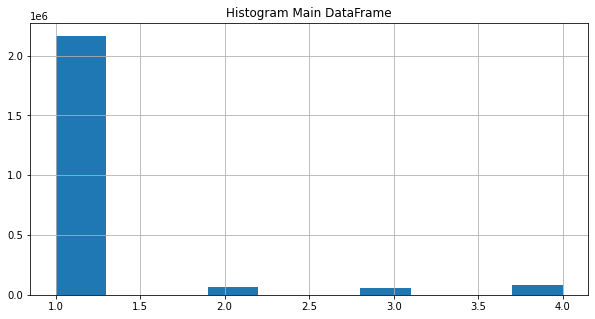

In [ ]:
plt.figure(figsize=(10,5))
df_main[154].hist()
plt.title("Histogram Main DataFrame")

In [ ]:
label_count = df_main[154].value_counts().tolist()

print(label_count)
min_val_label_count = np.min(label_count)

min_val_label_count

[2163975, 82061, 68601, 56581]


56581

> ## Data Subsetting

In [ ]:
df_main_subset = resample(df_main, replace=False, n_samples=int(len(df_main)*0.005), random_state=seed)
display(df_main_subset)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154
43535,0,0,0,0.089212,0.067889,0.067889,0.089212,0.144440,0.144440,0,0,0,0,1,1,1,1,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0.42495,0,0,...,0,0.0,1,0.000292,0.46154,0.0,0.003968,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0.5,1,0.00000,0.00000,0.00000,0.00000,0.0,0.00000,0.00000,0,0,0,0,0,0,0,0.000000,1
1045402,0,0,0,0.559490,0.001094,0.001094,0.559490,0.988240,0.988240,0,0,0,0,1,1,1,1,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0.72187,0,0,...,0,0.0,0,0.000000,0.00000,0.0,0.000000,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0.5,1,0.52826,0.00000,0.62024,0.00000,0.0,0.16667,0.16667,0,0,0,0,0,0,0,0.986740,1
1449339,0,0,0,0.804050,0.000882,0.000882,0.804050,0.057516,0.057516,0,0,0,0,1,1,1,1,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0.87628,0,0,...,0,0.0,0,0.000000,0.00000,0.0,0.000000,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0.5,1,0.00000,0.33333,0.00000,0.48354,0.0,0.00000,0.00000,0,0,0,0,0,0,0,0.043767,1
1100973,0,0,0,0.572950,0.000254,0.000254,0.572950,0.000000,0.000000,0,0,0,0,1,1,1,1,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0.73037,0,0,...,0,0.0,0,0.000000,0.00000,0.0,0.000000,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0.5,1,0.00000,0.00000,0.00000,0.00000,0.0,0.00000,0.00000,0,0,0,0,0,0,0,0.000000,1
1113156,0,0,0,0.576030,0.001034,0.001034,0.576030,0.988240,0.988240,0,0,0,0,1,1,1,1,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0.73231,0,0,...,0,0.0,0,0.000000,0.00000,0.0,0.000000,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0.5,1,0.57168,0.00000,0.49498,0.00000,0.0,0.16667,0.16667,0,0,0,0,0,0,0,0.986740,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
971754,0,0,0,0.544010,0.005427,0.005427,0.544010,0.000000,0.000000,0,0,0,0,1,1,1,1,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0.71210,0,0,...,0,0.0,0,0.000000,0.00000,0.0,0.000000,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0.5,1,0.00000,0.00000,0.00000,0.00000,0.0,0.00000,0.00000,0,0,0,0,0,0,0,0.000000,1
1894878,0,0,0,0.061089,0.000383,0.000383,0.061089,0.054902,0.054902,0,0,0,0,1,1,1,1,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0.88939,0,0,...,0,0.0,0,0.000000,0.00000,0.0,0.000000,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0.0,0,0.47521,0.00000,0.40258,0.00000,0.0,0.00000,0.00000,0,0,0,0,0,0,0,0.039788,1
257957,0,0,0,0.240850,0.008274,0.008274,0.240850,0.989540,0.989540,0,0,0,0,1,1,1,1,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0.52069,0,0,...,0,0.0,0,0.000000,0.00000,0.0,0.000000,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0.5,1,0.27041,0.00000,0.11219,0.00000,0.0,0.16667,0.16667,0,0,0,0,0,0,0,0.988060,1
108492,0,0,0,0.199560,0.000968,0.000968,0.199560,0.000000,0.000000,0,0,0,0,1,1,1,1,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0.49463,0,0,...,0,0.0,0,0.000000,0.00000,0.0,0.000000,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0.5,1,0.00000,0.00000,0.00000,0.00000,0.0,0.00000,0.00000,0,0,0,0,0,0,0,0.000000,1


###### $_{\textrm{Sanity Check}}$

In [ ]:
print("Min Max value throughout Dataset")
np.max(df_main_subset.iloc[:,:-1].max()), np.min(df_main_subset.iloc[:,:-1].min())

Min Max value throughout Dataset


(1.0, 0.0)

Original dataset distribution


Text(0.5, 1.0, 'Histogram Main Dataset SUBSET')

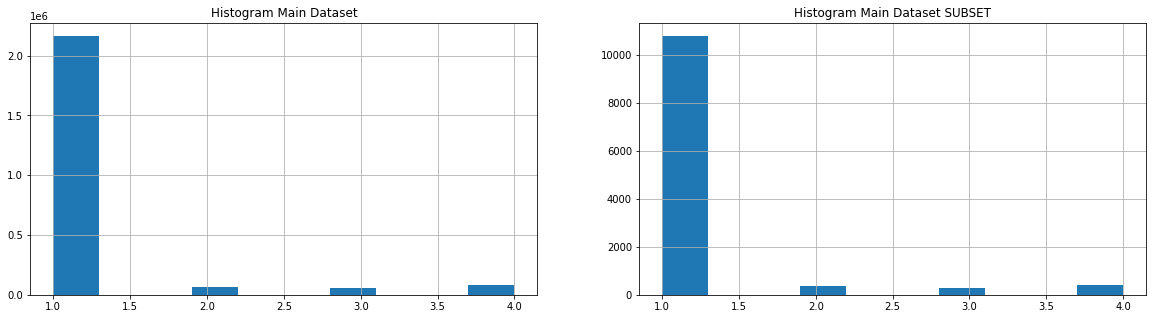

In [ ]:
print("Original dataset distribution")

plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
df_main[154].hist()
plt.title("Histogram Main Dataset")

plt.subplot(1,2,2)
df_main_subset[154].hist()
plt.title("Histogram Main Dataset SUBSET")

> ## Implementation RFECV **after** data split - using SVM estimator

>> ### _Data Split_

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df_main_subset.iloc[:,:-1], df_main_subset.iloc[:,-1], test_size=0.25, random_state=seed
)
print(len(y_train)," : ", len(y_test))

8892  :  2964


In [ ]:
train_df = X_train
train_df[154] = y_train
train_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154
2310439,0,0,0,0.87331,0.005875,0.005875,0.87331,0.000000,0.000000,0,0,0,0,1,1,1,1,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0.98507,0,0,...,0,0.0,0,0.000000,0.00000,0.0,0.00000,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0.0,0,0.000000,0.00000,0.00000,0.0,0.00000,0.00000,0.00000,0,0,0,0,0,0,0,0.000000,1
2209537,0,0,0,0.73852,0.001371,0.001371,0.73852,0.993460,0.993460,0,0,0,0,1,1,1,1,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0.96919,0,0,...,0,0.0,0,0.000000,0.00000,0.0,0.00000,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0.0,0,0.000000,0.00000,0.00000,0.0,0.36192,0.00000,0.00000,0,0,0,0,0,0,0,0.993370,1
499521,0,0,0,0.33326,0.001790,0.001790,0.33326,0.989540,0.989540,0,0,0,0,1,1,1,1,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0.57904,0,0,...,0,0.0,0,0.000000,0.00000,0.0,0.00000,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0.5,1,0.966780,0.00000,0.87287,0.0,0.00000,0.16667,0.16667,0,0,0,0,0,0,0,0.988060,1
2163258,0,0,0,0.62263,0.022914,0.022914,0.62263,0.113730,0.113730,0,0,0,0,1,1,1,1,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0.95554,0,0,...,0,0.0,1,0.000000,0.46154,0.0,0.66667,0,0.0,1.0,1.0,0.5,0.5,1.0,1,0,0,0.0,0.0,0,0,0,0.0,0,0.000000,0.00000,0.00000,0.0,0.00000,0.00000,0.00000,0,0,0,0,0,0,0,0.000000,1
1077749,0,0,0,0.56660,0.001122,0.001122,0.56660,0.988240,0.988240,0,0,0,0,1,1,1,1,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0.72636,0,0,...,0,0.0,0,0.000000,0.00000,0.0,0.00000,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0.5,1,0.694180,0.00000,0.43434,0.0,0.00000,0.16667,0.16667,0,0,0,0,0,0,0,0.986740,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184932,0,0,0,0.22598,0.001782,0.001782,0.22598,0.989540,0.989540,0,0,0,0,1,1,1,1,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0.51130,0,0,...,0,0.0,0,0.000000,0.00000,0.0,0.00000,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0.5,1,0.973600,0.00000,0.26407,0.0,0.00000,0.16667,0.16667,0,0,0,0,0,0,0,0.988060,1
1287506,0,0,0,0.63808,0.017607,0.017607,0.63808,0.037908,0.037908,0,0,0,0,1,1,1,1,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0.77150,0,0,...,0,0.0,0,0.000000,0.00000,0.0,0.00000,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0.5,1,0.035465,0.00000,0.20132,0.0,0.00000,0.00000,0.00000,0,0,0,0,0,0,0,0.023873,2
2286134,0,0,0,0.80979,0.002771,0.002771,0.80979,0.016993,0.016993,0,0,0,0,1,1,1,1,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0.97759,0,0,...,0,0.0,0,0.000000,0.00000,0.0,0.00000,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0.0,0,0.000005,0.33333,0.88128,0.0,0.00000,0.00000,0.00000,0,0,0,0,0,0,0,0.002652,2
2133993,0,0,0,0.57173,0.024441,0.024441,0.57173,0.009150,0.009150,0,0,0,0,1,1,1,1,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0.94955,0,0,...,0,0.0,0,0.000000,0.00000,0.0,0.00000,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0.0,0,0.000000,0.00000,0.00000,0.0,0.00000,0.00000,0.00000,0,0,0,0,0,0,0,0.000000,1


>> ### _Down & Up-sampling_

In [ ]:
train_df_label_1 = train_df[train_df.iloc[:,-1]==1]
train_df_label_2 = train_df[train_df.iloc[:,-1]==2]
train_df_label_3 = train_df[train_df.iloc[:,-1]==3]
train_df_label_4 = train_df[train_df.iloc[:,-1]==4]
# train_df_label_234 = train_df[train_df.iloc[:,-1]!=1]

In [ ]:
n_sample_perfeature = len(train_df)//4
n_sample_perfeature

2223

In [ ]:
## downsample
train_df_1 = resample(train_df_label_1, replace=False, n_samples=n_sample_perfeature)
## upsample
train_df_2 = resample(train_df_label_2, replace=True, n_samples=n_sample_perfeature)
train_df_3 = resample(train_df_label_3, replace=True, n_samples=n_sample_perfeature)
train_df_4 = resample(train_df_label_4, replace=True, n_samples=n_sample_perfeature)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154
0,0,0,0,0.96676,0.018152,0.018152,0.96676,0.110460,0.110460,0,0,0,0,1,1,1,1,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0.97901,0,0,...,0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0.5,1,0.0000,0.0,0.000000,0.0,0.0,0.00000,0.00000,0,0,0,0,0,0,0,0.078912,1
1,0,0,0,0.56409,0.001910,0.001910,0.56409,0.054902,0.054902,0,0,0,0,1,1,1,1,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0.72478,0,0,...,0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0.5,1,0.4527,0.0,0.506940,0.0,0.0,0.00000,0.00000,0,0,0,0,0,0,0,0.039788,1
2,0,0,0,0.23627,0.012633,0.012633,0.23627,0.989540,0.989540,0,0,0,0,1,1,1,1,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0.51780,0,0,...,0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0.5,1,0.4801,0.0,0.054774,0.0,0.0,0.16667,0.16667,0,0,0,0,0,0,0,0.988060,1
3,0,0,0,0.57598,0.000017,0.000017,0.57598,0.000000,0.000000,0,0,0,0,1,1,1,1,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0.95005,0,0,...,0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0.0,0,0.0000,0.0,0.000000,0.0,0.0,0.00000,0.00000,0,0,0,0,0,0,0,0.000000,1
4,0,0,0,0.79521,0.000903,0.000903,0.79521,0.000000,0.000000,0,0,0,0,1,1,1,1,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0.97587,0,0,...,0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0.0,0,0.0000,0.0,0.000000,0.0,0.0,0.00000,0.00000,0,0,0,0,0,0,0,0.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8887,0,0,0,0.80970,0.002647,0.002647,0.80970,0.037908,0.037908,0,0,0,0,1,1,1,1,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0.87985,0,0,...,0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0.5,1,0.1594,0.0,0.697500,0.0,0.0,0.00000,0.00000,0,0,0,0,0,0,0,0.023873,4
8888,0,0,0,0.40796,0.003911,0.003911,0.40796,0.037908,0.037908,0,0,0,0,1,1,1,1,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0.62620,0,0,...,0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0.5,1,0.1594,0.0,0.798520,0.0,0.0,0.00000,0.00000,0,0,0,0,0,0,0,0.023873,4
8889,0,0,0,0.43337,0.003166,0.003166,0.43337,0.037908,0.037908,0,0,0,0,1,1,1,1,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0.64225,0,0,...,0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0.5,1,0.1594,0.0,0.798520,0.0,0.0,0.00000,0.00000,0,0,0,0,0,0,0,0.023873,4
8890,0,0,0,0.40618,0.005447,0.005447,0.40618,0.037908,0.037908,0,0,0,0,1,1,1,1,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0.62508,0,0,...,0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0.5,1,0.1594,0.0,0.798520,0.0,0.0,0.00000,0.00000,0,0,0,0,0,0,0,0.023873,4


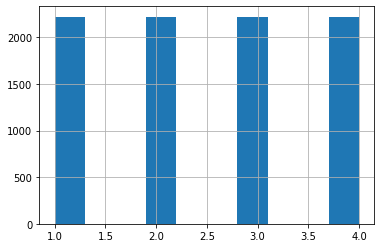

In [ ]:
df_train_balance = pd.concat([train_df_1, train_df_2, train_df_3, train_df_4], ignore_index=True)
display(df_train_balance)
df_train_balance[154].hist()

>> ### _RFECV Implementation_

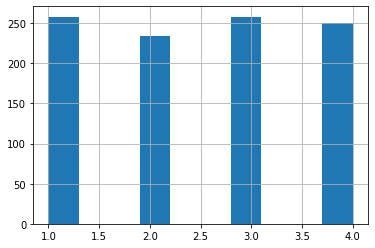

In [ ]:
## Based on balanced training data
df_train_sample = df_train_balance.sample(n=1000, random_state=seed)
X_df_train_sample = df_train_sample.iloc[:,:-1]
y_df_train_sample = df_train_sample.iloc[:,154]
y_df_train_sample.hist()

In [ ]:
X_df_train_sample

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153
5333,0,0,0,0.26130,0.002241,0.002241,0.26130,0.010458,0.010458,0,0,0,0,1,1,1,1,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0.53360,0,0,...,0,0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0.5,1,0.00000,0.0,0.00000,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0.000000
3405,0,0,0,0.61789,0.005773,0.005773,0.61789,0.037908,0.037908,0,0,0,0,1,1,1,1,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0.75875,0,0,...,0,0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0.5,1,0.34836,0.0,0.39104,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0.023873
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2310,0,0,0,0.62053,0.004571,0.004571,0.62053,0.037908,0.037908,0,0,0,0,1,1,1,1,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0.76041,0,0,...,0,0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0.5,1,0.35898,0.0,0.57125,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0.023873
1414,0,0,0,0.78260,0.002622,0.002622,0.78260,0.000000,0.000000,0,0,0,0,1,1,1,1,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0.97439,0,0,...,0,0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0.0,0,0.00000,0.0,0.00000,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0.000000


In [ ]:
estimator_svm = svm.SVR(kernel="linear")

df_train_rfecv = RFECV(estimator_svm, step=1, cv=5)
df_train_rfecv.fit(X_df_train_sample, y_df_train_sample)

RFECV(cv=5,
      estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
                    gamma='scale', kernel='linear', max_iter=-1, shrinking=True,
                    tol=0.001, verbose=False),
      min_features_to_select=1, n_jobs=None, scoring=None, step=1, verbose=0)

In [ ]:
df_train_rfecv_features = X_df_train_sample.columns[df_train_rfecv.support_].to_numpy()
df_train_rfecv_features

array([  3,   4,   5,   6,   7,   8,  13,  14,  15,  16,  17,  19,  37,
        42,  46,  47,  49,  50,  60,  63,  65,  66,  67,  68,  69,  70,
        71,  72,  74,  75,  76,  77,  78,  79,  80,  81,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  99, 100, 101, 103, 105, 106, 107,
       108, 109, 111, 117, 118, 119, 120, 121, 122, 125, 126, 127, 128,
       129, 137, 138, 139, 140, 141, 142, 143, 144, 145, 153])

In [ ]:
## Make sure rfecv_features length = NxN
rank_ls = df_train_rfecv.ranking_
idx=2
while (len(df_train_rfecv_features)<64):
  print('rank = ',idx, "; in index = [",np.where(rank_ls==idx),"]")
  df_train_rfecv_features = np.append(df_train_rfecv_features, np.where(rank_ls==idx))
  idx+=1

df_train_rfecv_features = df_train_rfecv_features[:64]
df_train_rfecv_features = sorted(df_train_rfecv_features)

print("------------------------------------------------------------------------------------------")
pd.set_option('display.max_rows', 5)
print("selected_rfecv_features : ", df_train_rfecv_features, "(",len(df_train_rfecv_features),")")

------------------------------------------------------------------------------------------
selected_rfecv_features :  [3, 4, 5, 6, 7, 8, 13, 14, 15, 16, 17, 19, 37, 42, 46, 47, 49, 50, 60, 63, 65, 66, 67, 68, 69, 70, 71, 72, 74, 75, 76, 77, 78, 79, 80, 81, 89, 90, 91, 92, 93, 94, 95, 96, 97, 99, 100, 101, 103, 105, 106, 107, 108, 109, 111, 117, 118, 119, 120, 121, 122, 125, 126, 127] ( 64 )


In [ ]:
df_train_rfecv_features_andlabels = np.append(df_train_rfecv_features,[154])
print("df_train RFECV :")
display(df_train_balance.loc[:, df_train_rfecv_features_andlabels])

df_train RFECV :


,3,4,5,6,7,8,13,14,15,16,17,19,37,42,46,47,49,50,60,63,65,66,67,68,69,70,71,72,74,75,76,77,78,79,80,81,89,90,91,92,93,94,95,96,97,99,100,101,103,105,106,107,108,109,111,117,118,119,120,121,122,125,126,127,154
0,0.96676,0.018152,0.018152,0.96676,0.110460,0.110460,1,1,1,1,1,1,0.97901,1,0.18868,0.98108,1,0,0.32394,0.72727,1.0,0.00000,1.0,0,0,0,0,0,0.000000,0.009578,0.082353,0.000289,0.003744,0.000295,0.0,0.034676,0,0,0.0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,1
1,0.56409,0.001910,0.001910,0.56409,0.054902,0.054902,1,1,1,1,1,1,0.72478,1,1.00000,0.98108,0,1,0.74648,0.90909,1.0,0.61538,0.5,0,0,0,0,1,0.003034,0.001127,0.023529,0.002020,0.002016,0.001474,0.0,0.702080,0,0,0.0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8890,0.40618,0.005447,0.005447,0.40618,0.037908,0.037908,1,1,1,1,1,1,0.62508,1,0.00000,0.98108,1,0,0.63380,0.72727,1.0,0.00000,0.5,0,0,0,0,1,0.021655,0.001127,0.005882,0.001443,0.001440,0.001474,0.0,0.004884,0,0,0.0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,4
8891,0.22505,0.003200,0.003200,0.22505,0.037908,0.037908,1,1,1,1,1,1,0.90870,1,0.00000,0.98108,1,0,0.65385,0.72727,1.0,0.00000,0.5,0,0,0,0,1,0.021655,0.015873,0.000685,0.027897,0.002173,0.002410,0.0,0.523320,0,0,0.0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,4


> ## Images Generator

>> ### _Features Selection_

>>> #### $_{\textrm{Functions}}$

In [ ]:
def features_selection_df(df_train, df_test, rfecv_selected_features):

  if (len(rfecv_selected_features)**(0.5))%1 != 0:
    raise ValueError("rfecv_selected_features not represent NxN matrix")

  ## remove attribute that not included in rfecv_selected_features and label
  rfecv_features_andlabels = np.append(df_train_rfecv_features,[154])

  train_Df = df_train.loc[:, rfecv_features_andlabels]
  test_Df = df_test.loc[:,rfecv_features_andlabels]

  return train_Df, test_Df

>>> #### $_{\textrm{Split main DF and select the features}}$

In [ ]:
# len(df_train_rfecv_features)

In [ ]:
test_df = X_test
test_df[154] = y_test
training_df, test_df = features_selection_df(df_train_balance, test_df, df_train_rfecv_features)
pd.set_option('display.max_rows', 10)

###### $_{\textrm{Sanity Check}}$

Training :


,3,4,5,6,7,8,13,14,15,16,17,19,37,42,46,47,49,50,60,63,65,66,67,68,69,70,71,72,74,75,76,77,78,79,80,81,89,90,91,92,93,94,95,96,97,99,100,101,103,105,106,107,108,109,111,117,118,119,120,121,122,125,126,127,154
0,0.96676,0.018152,0.018152,0.96676,0.110460,0.110460,1,1,1,1,1,1,0.97901,1,0.18868,0.98108,1,0,0.32394,0.72727,1.0,0.00000,1.0,0,0,0,0,0,0.000000,0.009578,0.082353,0.000289,0.003744,0.000295,0.0,0.034676,0,0,0.0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,1
1,0.56409,0.001910,0.001910,0.56409,0.054902,0.054902,1,1,1,1,1,1,0.72478,1,1.00000,0.98108,0,1,0.74648,0.90909,1.0,0.61538,0.5,0,0,0,0,1,0.003034,0.001127,0.023529,0.002020,0.002016,0.001474,0.0,0.702080,0,0,0.0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,1
2,0.23627,0.012633,0.012633,0.23627,0.989540,0.989540,1,1,1,1,1,1,0.51780,1,1.00000,0.98108,0,1,0.66197,0.90909,1.0,0.61538,1.0,0,1,0,0,1,0.003034,0.002253,0.017647,0.001731,0.001152,0.001474,0.0,0.920390,0,0,0.0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,1
3,0.57598,0.000017,0.000017,0.57598,0.000000,0.000000,1,1,1,1,1,1,0.95005,1,0.43396,0.98108,0,1,0.73077,0.65909,0.5,1.00000,0.0,0,0,0,0,0,0.000000,0.005291,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0,0,0.0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,1
4,0.79521,0.000903,0.000903,0.79521,0.000000,0.000000,1,1,1,1,1,1,0.97587,1,0.00000,0.98108,1,0,0.66667,0.65909,0.5,1.00000,0.0,0,0,0,0,0,0.000000,0.015873,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0,0,0.0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8887,0.80970,0.002647,0.002647,0.80970,0.037908,0.037908,1,1,1,1,1,1,0.87985,1,0.00000,0.98108,1,0,0.64789,0.72727,1.0,0.00000,0.5,0,0,0,0,1,0.021655,0.001127,0.005882,0.004039,0.005472,0.001474,0.0,0.999760,0,0,0.0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,4
8888,0.40796,0.003911,0.003911,0.40796,0.037908,0.037908,1,1,1,1,1,1,0.62620,1,0.00000,0.98108,1,0,0.63380,0.72727,1.0,0.00000,0.5,0,0,0,0,1,0.021655,0.001127,0.005882,0.001443,0.001440,0.001474,0.0,0.333820,0,0,0.0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,4
8889,0.43337,0.003166,0.003166,0.43337,0.037908,0.037908,1,1,1,1,1,1,0.64225,1,0.00000,0.98108,1,0,0.61972,0.72727,1.0,0.00000,0.5,0,0,0,0,1,0.021655,0.001127,0.005882,0.001443,0.001440,0.001474,0.0,0.008791,0,0,0.0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,4
8890,0.40618,0.005447,0.005447,0.40618,0.037908,0.037908,1,1,1,1,1,1,0.62508,1,0.00000,0.98108,1,0,0.63380,0.72727,1.0,0.00000,0.5,0,0,0,0,1,0.021655,0.001127,0.005882,0.001443,0.001440,0.001474,0.0,0.004884,0,0,0.0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,4


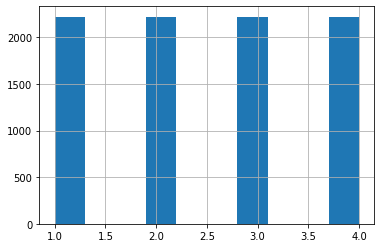

In [ ]:
display(training_df[154].hist())
print("Training :")
training_df

Testing 


,3,4,5,6,7,8,13,14,15,16,17,19,37,42,46,47,49,50,60,63,65,66,67,68,69,70,71,72,74,75,76,77,78,79,80,81,89,90,91,92,93,94,95,96,97,99,100,101,103,105,106,107,108,109,111,117,118,119,120,121,122,125,126,127,154
1961320,0.10191,0.001353,0.001353,0.10191,0.988240,0.988240,1,1,1,1,1,1,0.89420,1,1.00000,0.98108,0,1,0.73077,0.90909,1.0,0.61538,1.0,0,0,0,0,1,0.003034,0.005291,0.000343,0.002146,0.000128,0.002410,0.0,0.464710,0,0,0.00000,0,0,0,0,0,0,0,0,0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0,0.000000,0.00000,0.0,0.000000,0,0.000000,0.000000,0.000000,1
1334492,0.67561,0.012768,0.012768,0.67561,0.319610,0.319610,1,1,1,1,1,1,0.79519,1,0.00000,0.98108,1,0,0.69014,0.11364,0.0,0.38462,0.0,0,0,0,0,0,0.021655,0.011831,0.100000,0.570690,0.571430,0.567090,0.0,0.035165,1,1,0.98473,1,0,0,0,1,1,1,1,0,0.0,0.0,0.000000,0.12967,0.0,0.0,0.0,1,0.568140,0.46154,0.0,0.000000,0,0.000000,0.000000,0.000000,3
1724091,0.92642,0.010064,0.010064,0.92642,0.988240,0.988240,1,1,1,1,1,1,0.95355,1,1.00000,0.98108,0,1,0.70423,0.72727,1.0,0.00000,1.0,0,0,0,0,1,0.003034,0.011831,0.100000,0.001731,0.001152,0.001474,0.0,0.682300,0,0,0.00000,0,0,0,0,0,0,0,0,0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0,0.000000,0.00000,0.0,0.000000,0,0.000000,0.000000,0.000000,1
336781,0.25965,0.004208,0.004208,0.25965,0.086275,0.086275,1,1,1,1,1,1,0.53257,1,0.00000,0.98108,1,0,0.23944,0.00000,0.0,0.00000,0.0,0,0,0,0,0,0.022069,0.003944,0.200000,0.007213,0.008353,0.000295,0.0,0.533820,1,0,0.00000,0,1,0,0,0,1,0,0,0,1.0,0.0,0.000000,0.00000,0.0,0.0,0.0,1,0.000292,0.00000,0.0,0.000000,0,0.000000,0.000000,0.000000,1
459912,0.29660,0.001802,0.001802,0.29660,0.989540,0.989540,1,1,1,1,1,1,0.55589,1,0.66038,0.98108,0,1,0.66197,0.90909,1.0,0.61538,1.0,0,0,0,0,1,0.003034,0.011268,0.094118,0.001731,0.001152,0.001474,0.0,0.110870,0,0,0.00000,0,0,0,0,0,0,0,0,0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0,0.000000,0.00000,0.0,0.000000,0,0.000000,0.000000,0.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
874167,0.52456,0.001973,0.001973,0.52456,0.054902,0.054902,1,1,1,1,1,1,0.69982,1,1.00000,0.98108,0,1,0.70423,0.90909,1.0,0.61538,0.5,0,0,0,0,1,0.003034,0.001127,0.023529,0.002020,0.002016,0.001474,0.0,0.387060,0,0,0.00000,0,0,0,0,0,0,0,0,0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0,0.000000,0.00000,0.0,0.000000,0,0.000000,0.000000,0.000000,1
1230445,0.60870,0.015229,0.015229,0.60870,0.077778,0.077778,1,1,1,1,1,1,0.75294,1,0.00000,0.98108,1,0,0.49296,0.18182,0.0,0.61538,0.0,0,0,0,0,0,0.000000,0.000563,0.005882,0.001154,0.001152,0.001180,0.0,0.228080,1,0,0.00000,1,0,0,0,0,1,0,0,0,0.0,0.0,0.053399,0.00153,0.0,0.0,0.0,1,0.001167,0.46154,0.0,0.003968,0,0.000015,0.007843,0.000031,1
914901,0.53141,0.000325,0.000325,0.53141,0.054902,0.054902,1,1,1,1,1,1,0.70415,1,1.00000,0.98108,0,1,0.66197,0.90909,1.0,0.61538,0.5,0,0,0,0,1,0.003034,0.001127,0.023529,0.002020,0.002016,0.001474,0.0,0.888640,0,0,0.00000,0,0,0,0,0,0,0,0,0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0,0.000000,0.00000,0.0,0.000000,0,0.000000,0.000000,0.000000,1
1114958,0.57646,0.001322,0.001322,0.57646,0.988240,0.988240,1,1,1,1,1,1,0.73259,1,1.00000,0.98108,0,1,0.70423,0.90909,1.0,0.61538,1.0,0,0,0,0,1,0.003034,0.002253,0.017647,0.001731,0.001152,0.001474,0.0,0.987790,0,0,0.00000,0,0,0,0,0,0,0,0,0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0,0.000000,0.00000,0.0,0.000000,0,0.000000,0.000000,0.000000,1


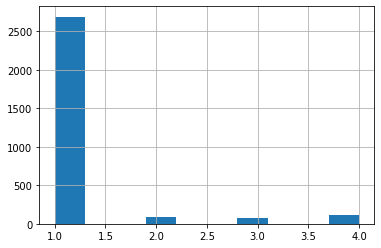

In [ ]:
display(test_df[154].hist())
print("Testing ")
test_df

### **$_{\textrm{Sanity check before generating image (tabular classification)}}$**

In [ ]:
## RFECV
X_train_caseB_rfecv, _, y_train_caseB_rfecv, _ = train_test_split(
    training_df.iloc[:,:-1], training_df.iloc[:,-1], test_size=0.001, random_state=seed
)
_, X_test_caseB_rfecv, _, y_test_caseB_rfecv = train_test_split(
    test_df.iloc[:,:-1], test_df.iloc[:,-1], test_size=0.999, random_state=seed
)
print("train : test")
print(len(y_train_caseB_rfecv)," : ",len(y_test_caseB_rfecv))
print("train : test (Ratio)")
train_ratio = len(y_train_caseB_rfecv) / (len(y_train_caseB_rfecv)+len(y_test_caseB_rfecv))
test_ratio = len(y_test_caseB_rfecv) / (len(y_train_caseB_rfecv)+len(y_test_caseB_rfecv))
print(train_ratio," : ",test_ratio)

train : test
8883  :  2962
train : test (Ratio)
0.7499366821443647  :  0.2500633178556353


In [ ]:
linear = svm.LinearSVC(random_state=seed).fit(X_train_caseB_rfecv, y_train_caseB_rfecv)
rbf = svm.SVC(kernel='rbf', gamma=0.5, C=0.1).fit(X_train_caseB_rfecv, y_train_caseB_rfecv)
poly = svm.SVC(kernel='poly', degree=3, C=1).fit(X_train_caseB_rfecv, y_train_caseB_rfecv)

lin_pred = linear.predict(X_test_caseB_rfecv)
poly_pred = poly.predict(X_test_caseB_rfecv)
rbf_pred = rbf.predict(X_test_caseB_rfecv)

In [ ]:
lin_accuracy = accuracy_score(y_test_caseB_rfecv, lin_pred)
lin_precision = precision_score(y_test_caseB_rfecv, lin_pred, average='weighted')
lin_recall = recall_score(y_test_caseB_rfecv, lin_pred, average='weighted')
lin_f1 = f1_score(y_test_caseB_rfecv, lin_pred, average='weighted')
print('Accuracy (Linear Kernel): ', "%.2f" % (lin_accuracy*100))
print('Precision (Linear Kernel): ', "%.2f" % (lin_precision*100))
print('Recall (Linear Kernel): ', "%.2f" % (lin_recall*100))
print('F1 (Linear Kernel): ', "%.2f" % (lin_f1*100))

print("----------------------------------------------------------------")

poly_accuracy = accuracy_score(y_test_caseB_rfecv, poly_pred)
poly_precision = precision_score(y_test_caseB_rfecv, poly_pred, average='weighted')
poly_recall = recall_score(y_test_caseB_rfecv, poly_pred, average='weighted')
poly_f1 = f1_score(y_test_caseB_rfecv, poly_pred, average='weighted')
print('Accuracy (Polynomial Kernel): ', "%.2f" % (poly_accuracy*100))
print('Precision (Polynomial Kernel): ', "%.2f" % (poly_precision*100))
print('Recall (Polynomial Kernel): ', "%.2f" % (poly_recall*100))
print('F1 (Polynomial Kernel): ', "%.2f" % (poly_f1*100))

print("----------------------------------------------------------------")

rbf_accuracy = accuracy_score(y_test_caseB_rfecv, rbf_pred)
rbf_precision = precision_score(y_test_caseB_rfecv, rbf_pred, average='weighted')
rbf_recall = recall_score(y_test_caseB_rfecv, rbf_pred, average='weighted')
rbf_f1 = f1_score(y_test_caseB_rfecv, rbf_pred, average='weighted')
print('Accuracy (RBF Kernel): ', "%.2f" % (rbf_accuracy*100))
print('Precision (RBF Kernel): ', "%.2f" % (rbf_precision*100))
print('Recall (RBF Kernel): ', "%.2f" % (rbf_recall*100))
print('F1 (RBF Kernel): ', "%.2f" % (rbf_f1*100))

Accuracy (Linear Kernel):  97.54
Precision (Linear Kernel):  98.23
Recall (Linear Kernel):  97.54
F1 (Linear Kernel):  97.73
----------------------------------------------------------------
Accuracy (Polynomial Kernel):  97.50
Precision (Polynomial Kernel):  98.14
Recall (Polynomial Kernel):  97.50
F1 (Polynomial Kernel):  97.70
----------------------------------------------------------------
Accuracy (RBF Kernel):  96.19
Precision (RBF Kernel):  97.39
Recall (RBF Kernel):  96.19
F1 (RBF Kernel):  96.55


>> ### _Generating Images_

>>> #### $_{\textrm{Functions}}$

In [ ]:
def save_data2img(images, label, img_index, folder_path, additional_fname='', path_toimg=toimg_path):
  img = Image.fromarray(images, 'RGB')
  # display(plt.imshow(img))
  img_name = str(label)+str(img_index)+"_"+".jpg"
  try:
    img = img.save(path_toimg/str(folder_path)/str(label)/img_name)
  except:
    # new_path = path_toimg+str(folder_path)+str(label)
    # new_path = path_toimg
    # print(new_path)
    os.mkdir(path_toimg/str(folder_path)/str(label))
    img = img.save(path_toimg/str(folder_path)/str(label)/img_name)

In [ ]:
def data2img(dataframe, df_labels, folder_path, resolution = (224,224)):
  len_attributes=len(dataframe.columns)

  n_tile = len_attributes**(0.5) ## tile size n_tile*n_tile
  dim = int(n_tile)
  if n_tile%1 == 0:
    
    tile_size = int(resolution[0]//n_tile)

    for idx in tqdm(range(len(dataframe)), desc="data2img "):

      ## generate image for each item :

      frame = np.zeros((*resolution, 3), dtype=np.uint8) ## reset frame to black for every image
      n_row = 0
      n_col = 0
      name_using_decval = []

      item =  list(dataframe.iloc[idx,:])
      for attribute in item:
        dec_val = int(attribute*510) ## 510 = 2*255 (255 range for Red + 255 range for Blue)

        ## make discrete decimal value by rounding base on len_attributes
        divider = int(510//len_attributes)
        discrete_decval = (dec_val//divider)*divider

        if discrete_decval <= 255:
          dec_conv = 255-discrete_decval
          hex_value = [0,0,dec_conv]
          name = 'b'+str(dec_conv)
        else:
          dec_conv = discrete_decval-255
          hex_value = [dec_conv,0,0]
          name = 'r'+str(dec_conv)

        name_using_decval.append(name)

        ## convert decimal value to hexadecimal value for color encoding

        for i_row in range((n_row*tile_size), (n_row*tile_size)+tile_size-1 ):
          for j_col in range((n_col*tile_size), (n_col*tile_size)+tile_size-1 ):
            frame[i_row][j_col] = np.array(hex_value)
            
        if n_col==(n_tile-1):
          n_col=0
          n_row+=1
        else:
          n_col+=1

      ## save image base on labels:
      name_using_decval_str = [str(int) for int in name_using_decval]
      additional_fname = "-".join(name_using_decval_str)
      save_data2img(frame, df_labels.iloc[idx].values[0], idx, folder_path, additional_fname)

    print("\nSaved in : ", str(toimg_path/str(folder_path)))
    print("----------------------------------------------------------")
    print("\n")
    print("\n")

  else:
    raise(ValueError("Number of attributes could not formed NxN images"))

>>> #### $_{\textrm{Generate Images}}$

In [ ]:
train_attr = training_df.iloc[:,:-1] 
train_label = training_df.iloc[:,-1:]

test_attr = test_df.iloc[:,:-1] 
test_label = test_df.iloc[:,-1:] 

## Generate Train Images
data2img(train_attr, train_label, "training")
## Generate Test Images
data2img(test_attr, test_label, "testing")

data2img : 100%|██████████| 8892/8892 [15:50<00:00,  9.35it/s]



Saved in :  gdrive/My Drive/IDS_research/config3.6/toimages/training
----------------------------------------------------------






data2img : 100%|██████████| 2964/2964 [05:18<00:00,  9.31it/s]


Saved in :  gdrive/My Drive/IDS_research/config3.6/toimages/testing
----------------------------------------------------------






# **Data split (training, validation, testing)**

In [5]:
data_transforms = transforms.Compose([
                                      transforms.ToTensor(), 
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])
                                      ])

> ## $_{\textrm{Functions}}$

In [6]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

> ## _Train, Validation, and Training Data_

In [7]:
## Load Training Images
training_image_datasets = datasets.ImageFolder(Path(toimg_path)/"training",data_transforms)
training_cls_len = len(training_image_datasets.class_to_idx)
training_image_datasets.class_to_idx

{'1': 0, '2': 1, '3': 2, '4': 3}

In [8]:
## Load Testing Images
test_image_datasets = datasets.ImageFolder(Path(toimg_path)/"testing",data_transforms)
downstram_cls_len = len(test_image_datasets.class_to_idx)
test_image_datasets.class_to_idx

{'1': 0, '2': 1, '3': 2, '4': 3}

In [9]:
## Define train_set from BALANCE TESTING IMAGES
train_set, _ = train_test_split(training_image_datasets, test_size=0.25, random_state=seed)

## Define test_set and val_set from IMBALANCE TESTING IMAGES
test_set, val_set = train_test_split(test_image_datasets, test_size=0.25, random_state=seed)

## Define dataloader
training_dataloader = {'train': DataLoader(train_set, batch_size=16, shuffle=True),
                       'val': DataLoader(val_set, batch_size=16, shuffle=False)
                       }
test_dataloader = {
                   'test': DataLoader(test_set, batch_size=16, shuffle=False)
                   }


In [10]:
print("Training Dataloader (train:val): [",len(training_dataloader['train'].dataset)," : ",len(training_dataloader['val'].dataset),"]")
print("Test Dataloader (test): [",len(test_dataloader['test'].dataset),"]")

Training Dataloader (train:val): [ 6669  :  741 ]
Test Dataloader (test): [ 2223 ]


In [11]:
total_images = len(training_dataloader['train'].dataset)+len(training_dataloader['val'].dataset)+len(test_dataloader['test'].dataset)
len_data_train = len(training_dataloader['train'].dataset)
len_data_val = len(training_dataloader['val'].dataset)
len_data_test = len(test_dataloader['test'].dataset)

print("===== DATA RATIO (T:V:T) =====")
print(len_data_train/total_images," : ",len_data_val/total_images," : ",len_data_test/total_images)
print(int((len_data_train/total_images)*100)," : ",int((len_data_val/total_images)*100)," : ",int((len_data_test/total_images)*100))

===== DATA RATIO (T:V:T) =====
0.6923076923076923  :  0.07692307692307693  :  0.23076923076923078
69  :  7  :  23


## **$_{\textrm{Sanity check before CNN Modeling}}$**

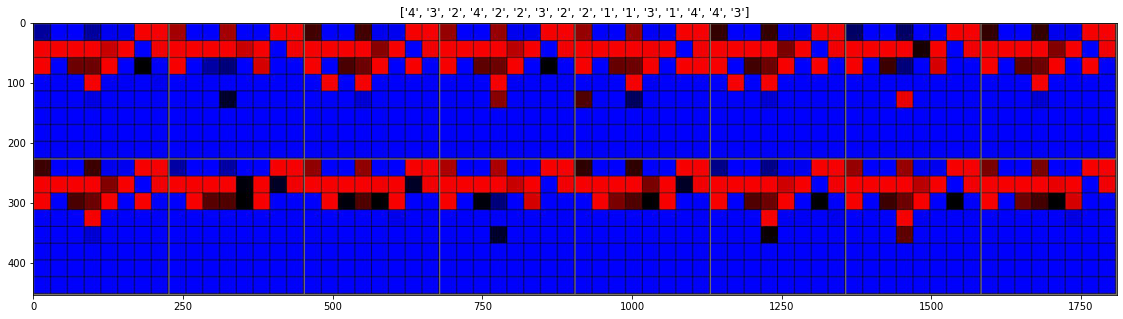

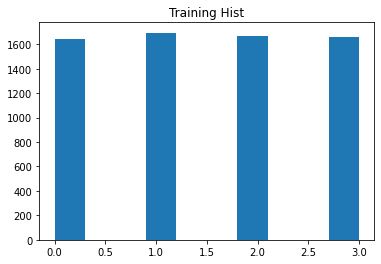

In [12]:
# Get a batch of training data
inputs, classes = next(iter(training_dataloader['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
plt.figure(figsize=(20,5))
imshow(out, title=[training_image_datasets.classes[x] for x in classes])

train_cls = []
for inp, cls in training_dataloader['train']:
  train_cls = np.append(train_cls, cls.tolist())

plt.hist(train_cls)
plt.title('Training Hist')
plt.show()

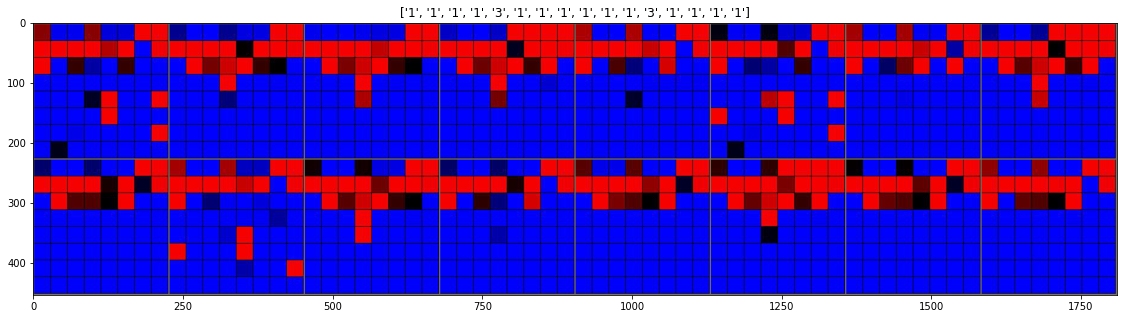

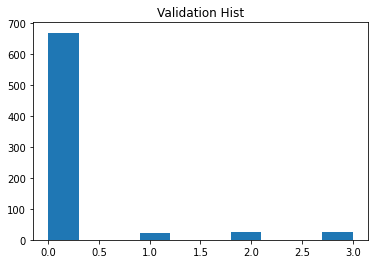

In [13]:
# Get a batch of validation data
inputs, classes = next(iter(training_dataloader['val']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
plt.figure(figsize=(20,5))
imshow(out, title=[training_image_datasets.classes[x] for x in classes])

val_cls = []
for inp, cls in training_dataloader['val']:
  val_cls = np.append(val_cls, cls.tolist())

plt.hist(val_cls)
plt.title('Validation Hist')
plt.show()

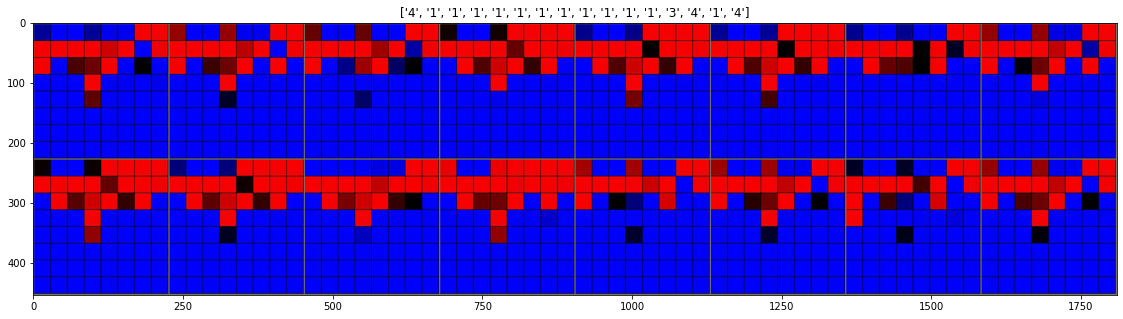

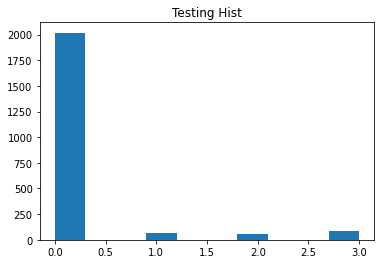

In [14]:
# Get a batch of training data
inputs, classes = next(iter(test_dataloader['test']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
plt.figure(figsize=(20,5))
imshow(out, title=[test_image_datasets.classes[x] for x in classes])

test_cls = []
for inp, cls in test_dataloader['test']:
  test_cls = np.append(test_cls, cls.tolist())

plt.hist(test_cls)
plt.title('Testing Hist')
plt.show()

# **CNN Training**

> ## $_{\textrm{Functions}}$

>> ### $_{\textrm{Train Functions}}$

In [15]:
## based on https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html with modification
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs, ploting=True):
  since = time.time()

  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0

  total_train_loss = list()
  total_val_loss = list()
  total_train_acc = list()
  total_val_acc = list()
  y_pred_confmatrix = list()
  y_true_confmatrix = list()

  print("\n")
  for epoch in tqdm(range(num_epochs), desc='Epoch :'):
    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
      inputs_tensor_batch = list()
      y_pred = list()
      y_true = list()

      if phase == 'train':
        model.train()  # Set model to training mode
      else:
        model.eval()   # Set model to evaluate mode

      running_loss = 0.0
      running_corrects = 0

      ######## Iterate over data START. ########
      for inputs, labels in dataloaders[phase]:
        inputs = inputs.to(device)
        labels = labels.to(device)
          
        ## zero the parameter gradients
        optimizer.zero_grad()

        ## forward
        ## track history if only in train
        with torch.set_grad_enabled(phase == 'train'):
          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)
          loss = criterion(outputs, labels)

          ## backward + optimize only if in training phase
          if phase == 'train':
            loss.backward()
            optimizer.step()

        ## statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

        ## Record label, prediction and each input
        prediction_res = preds
        true_labels = labels.data
        input_tensor_data = inputs.data

        y_pred.append(list(prediction_res.cpu().numpy()))
        y_true.append(list(true_labels.cpu().numpy()))
      
      ######## Iterate over data END. ########

      if phase == 'train':
        scheduler.step()

      epoch_loss = running_loss / len(dataloaders[phase].dataset)
      epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

      ## Record loss and acc to display in graph
      if phase == "train":
        total_train_loss.append(epoch_loss)
        total_train_acc.append(epoch_acc.item())
      else:
        total_val_loss.append(epoch_loss)
        total_val_acc.append(epoch_acc.item())

      ## deep copy the model and make dictionary of recorded label, prediction and input for <phase == 'test'>
      if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc

        best_model_wts = copy.deepcopy(model.state_dict())

        y_pred_confmatrix = list(np.concatenate(y_pred).flat)
        y_true_confmatrix = list(np.concatenate(y_true).flat)

        ## input dictionary
        recorded_val = {'true_labels':y_true_confmatrix, 'predicted_labels':y_pred_confmatrix}

  ## display in DataFrame format
  result_dict = {'train_loss': total_train_loss,
                 'val_loss':total_val_loss,
                 'train_acc':total_train_acc,
                 'val_acc': total_val_acc}
  result_df = pd.DataFrame(result_dict)
  display(result_df)

  print()

  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(
      time_elapsed // 60, time_elapsed % 60))
  print('Best val Acc: {:4f}'.format(best_acc))

  ## Ploting loss and accuracy

  if ploting:
    plt.figure(figsize=(15,5))

    plt.subplot(1,2,1)
    loss_plot = plt.plot(total_train_loss, label="train loss")
    loss_plot = plt.plot(total_val_loss, label="val loss")
    plt.title("Loss")
    plt.ylabel('loss')
    plt.xlabel('epoch #')
    plt.legend()
    loss_dict = {'train_loss': total_train_loss,
                'val_loss': total_val_loss,}

    plt.subplot(1,2,2)
    acc_plot = plt.plot(total_train_acc, label="train acc")
    acc_plot = plt.plot(total_val_acc, label="val acc")
    plt.title("Accuracy")
    plt.ylabel('acc')
    plt.xlabel('epoch #')
    plt.legend()
    acc_dict = {'train_acc': total_train_acc,
                'val_acc': total_val_acc,}
    plt.show()

  # load best model weights
  model.load_state_dict(best_model_wts)

  ## Matrics 
  acc = accuracy_score(recorded_val['true_labels'], recorded_val['predicted_labels'])
  conf_mat = confusion_matrix(recorded_val['true_labels'], recorded_val['predicted_labels'])
  precision = precision_score(recorded_val['true_labels'], recorded_val['predicted_labels'], average='weighted')
  recall = recall_score(recorded_val['true_labels'], recorded_val['predicted_labels'], average='weighted')
  f_scr = f1_score(recorded_val['true_labels'], recorded_val['predicted_labels'], average='weighted')

  return model, result_dict, acc, conf_mat, precision, recall, f_scr, recorded_val

>> ### $_{\textrm{Learner Functions (Finetuning)}}$

In [16]:
def learner(arch, dataloader, len_cls, num_epochs, fc_config="default",
            optimizer_mode='sgd', lr_val=0.005, momentum_val=0.9, decay=1e-6,
            display_model_arch = False):
  ## model architecture
  model = arch
  num_ftrs = model.fc.in_features
  if fc_config == 'multi':
    raise ValueError("unavailable fc_config.")
    # model.fc = nn.Sequential(nn.BatchNorm1d(num_ftrs),
    #                         nn.Linear(num_ftrs, 1024),
    #                         nn.ReLU(inplace=True),
    #                         nn.BatchNorm1d(1024),
    #                         nn.Linear(1024,512),
    #                         nn.ReLU(inplace=True),
    #                         nn.BatchNorm1d(512),
    #                         nn.Linear(512,256),
    #                         nn.ReLU(inplace=True),
    #                         nn.BatchNorm1d(256),
    #                         nn.Linear(256,len_cls),
    #                         nn.Softmax(dim=1)
    #                         )
  elif fc_config == 'default':
    model.fc = nn.Sequential(nn.Linear(num_ftrs, 512),
                             nn.BatchNorm1d(512),
                             nn.ReLU(inplace=True),
                             nn.Linear(512, len_cls),
                             nn.Softmax(dim=1)
                            )
  else:
    raise ValueError("unknown fc_config. Available config ['default', 'multi']")


  model = model.to(device)
  
  if display_model_arch:
    display(model)

  model_criterion = nn.CrossEntropyLoss()

  if optimizer_mode == 'sgd':
    model_optimizer = optim.SGD(model.parameters(), lr=lr_val, momentum=momentum_val)
  elif optimizer_mode == 'adam':
    model_optimizer = optim.Adam(model.parameters(), lr=lr_val, weight_decay=decay)
  else:
    raise ValueError("unknown model_optimizer. Available config ['sgd', 'adam']")

  exp_lr_scheduler = lr_scheduler.OneCycleLR(model_optimizer, max_lr=lr_val, 
                                             steps_per_epoch=2*len(dataloader), 
                                             epochs=num_epochs)

  ret_dict= {'model': model, 'criterion':model_criterion,
             'optimizer': model_optimizer, 'lr_scheduler':exp_lr_scheduler}
  
  return ret_dict

>> ### $_{\textrm{Test Functions}}$

In [17]:
def test_model(model_learner, valid_dl):
  model = model_learner['model']
  criterion = model_learner['criterion']
  model.eval()
  correct_pred = 0
  false_pred = 0
  y_true = list()
  y_pred = list()
  running_loss = 0.0
  running_corrects = 0
  inputs_tensor_batch = list()
  
  ######## Iterate over data START. ########
  for inputs, labels in tqdm(valid_dl['test'], desc="Testing "):
    inputs = inputs.to(device)
    labels = labels.to(device)

    
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    loss = criterion(outputs, labels)

    prediction_res = preds
    true_labels = labels.data
    input_tensor_data = inputs.data

    y_pred.append(list(prediction_res.cpu().numpy()))
    y_true.append(list(true_labels.cpu().numpy()))
    inputs_tensor_batch.append(list(input_tensor_data.cpu().numpy()))
    
    running_loss += loss.item() * inputs.size(0)
    running_corrects += torch.sum(preds == labels.data)
  ######## Iterate over data END. ########

  y_pred_confmatrix = list(np.concatenate(y_pred).flat)
  y_true_confmatrix = list(np.concatenate(y_true).flat)

  ## input dictionary
  recorded_test = {'inputs': inputs_tensor_batch, 'true_labels':y_true_confmatrix, 'predicted_labels':y_pred_confmatrix}

  loss = running_loss / len(valid_dl['test'].dataset)

  acc = running_corrects.double() / len(valid_dl['test'].dataset)
  conf_mat = confusion_matrix(recorded_test['true_labels'], recorded_test['predicted_labels'])
  precision = precision_score(recorded_test['true_labels'], recorded_test['predicted_labels'], average='weighted')
  recall = recall_score(recorded_test['true_labels'], recorded_test['predicted_labels'], average='weighted')
  f_scr = f1_score(recorded_test['true_labels'], recorded_test['predicted_labels'], average='weighted')
  
  return acc, loss, conf_mat, precision, recall, f_scr, recorded_test

>> ### $_{\textrm{During Training Functions}}$

In [18]:
def downstream_task(training_dataloader, test_dataloader, downstram_cls_len, epoch, 
                    pretrained_arch, mode, 
                    flag_show_model_detail = False):
  
  training_res = list()
  acc_list = list()
  loss_list = list()
  f1_score_list = list()

  best_test_acc = 0.0
  best_input_dict_test = None
  for i in range(3):
    print(">>>> loop %d : "%(i))
    learner_downstrm = learner(models.resnet50(pretrained=pretrained_arch), training_dataloader, downstram_cls_len,
                               num_epochs=epoch, fc_config="default", optimizer_mode='sgd', lr_val=0.005, momentum_val=0.9)


    if flag_show_model_detail:
      print("\n\n###################################################################################")
      print(mode)
      print(learner_downstrm['model'])
      print("###################################################################################\n\n")
      flag_show_model_detail = False

    pretext_trained, training_result_dict, acc_val, confmatrix_val, precision_val, recall_val, f1_score_val, _ = train_model(learner_downstrm['model'],
                                                                                                                              training_dataloader,
                                                                                                                              learner_downstrm['criterion'],
                                                                                                                              learner_downstrm['optimizer'],
                                                                                                                              learner_downstrm['lr_scheduler'],
                                                                                                                              num_epochs=epoch,
                                                                                                                              ploting=False)
    print("================================== VALIDATING ==================================")
    print('Best Val Acc using sklearn: ',acc_val)
    print(" Val Precision : %.4f \n"%(precision_val))
    print(" Val Recall : %.4f \n"%(recall_val))
    print(" Val F1 Score : %.4f \n"%(f1_score_val))
    
    ## Record training result for every loop
    training_res.append(training_result_dict)
    
    ## save training model for testing
    trained_model_path = str(mode)+"_dwnstrm_model.pth"
    torch.save(pretext_trained.state_dict(), 
              path_models/trained_model_path)

    
    ## Test model 
    test_learner = learner(models.resnet50(pretrained=pretrained_arch), test_dataloader, downstram_cls_len,
                            num_epochs=epoch, fc_config="default", optimizer_mode='sgd', lr_val=0.005, momentum_val=0.9)
    test_learner['model'].load_state_dict(torch.load(path_models/trained_model_path))

    acc_test, loss_test, conf_mat_test, precision_test, recall_test, f1_score_test, input_dict_test = test_model(test_learner, test_dataloader)

    ## Matrics Evaluation
    print("================================== TESTING ==================================")
    print("\n Test Accuracy : %.4f "%(acc_test))
    print(" Test Loss : %.4f \n"%(loss_test))
    print(" Test Precision : %.4f \n"%(precision_test))
    print(" Test Recall : %.4f \n"%(recall_test))
    print(" Test F1 Score : %.4f \n"%(f1_score_test))
    acc_list.append(acc_test.item())
    loss_list.append(loss_test)
    f1_score_list.append(f1_score_test)

    if best_test_acc < acc_test:
      best_test_acc = acc_test
      best_input_dict_test = input_dict_test

      

    ## Plot Confussion Metric
    plt.figure(figsize=(15,5))

    plt.subplot(1,2,1)
    training_matric = sns.heatmap(confmatrix_val, annot=True, fmt='d', cmap='Blues')
    plt.title('Best Training Validation ConfMet')
    plt.ylabel('True')
    plt.xlabel('Pred')

    plt.subplot(1,2,2)
    valid_matric = sns.heatmap(conf_mat_test, annot=True, fmt='d', cmap='Blues')
    plt.title('Test ConfMet')
    plt.ylabel('True')
    plt.xlabel('Pred')
    plt.show()


  return acc_list, loss_list, f1_score_list, training_res, best_input_dict_test, trained_model_path

>>> #### $_{\textrm{Display graphic}}$

In [19]:
## Plot Training graph
def plot_training(training_result, start_loss, end_loss, start_acc, end_acc):
  plt.figure(figsize=(30,8))

  ## LOSS
  plt.subplot(1,4,1)
  for idx in range(len(training_result)):
    training_loss_plot = plt.plot(training_result[idx]['train_loss'], label="loop "+str(idx))
  axes = plt.gca()
  # axes.set_ylim([start_loss,end_loss])
  plt.title('Training loss')
  plt.legend()
  plt.ylabel('loss')
  plt.xlabel('epoch')

  plt.subplot(1,4,2)
  for idx in range(len(training_result)):
    validation_loss_plot = plt.plot(training_result[idx]['val_loss'], label="loop "+str(idx))
  axes = plt.gca()
  # axes.set_ylim([start_loss,end_loss])
  plt.title('Validation loss')
  plt.legend()
  plt.ylabel('loss')
  plt.xlabel('epoch')

  ## ACC
  plt.subplot(1,4,3)
  for idx in range(len(training_result)):
    training_loss_plot = plt.plot(training_result[idx]['train_acc'], label="loop "+str(idx))
  axes = plt.gca()
  # axes.set_ylim([start_acc,end_acc])
  plt.title('Training acc')
  plt.legend()
  plt.ylabel('acc')
  plt.xlabel('epoch')

  plt.subplot(1,4,4)
  for idx in range(len(training_result)):
    validation_loss_plot = plt.plot(training_result[idx]['val_acc'], label="loop "+str(idx))
  axes = plt.gca()
  # axes.set_ylim([start_acc,end_acc])
  plt.title('Validation acc')
  plt.legend()
  plt.ylabel('acc')
  plt.xlabel('epoch')

  plt.show()

> ## _Training the model and Testing_

>>>> loop 0 : 




Epoch ::   0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
Epoch :: 100%|██████████| 8/8 [20:38<00:00, 154.78s/it]


,train_loss,val_loss,train_acc,val_acc
0,0.812715,0.791920,0.964912,0.997301
1,0.755438,0.761712,0.995951,0.995951
2,0.757291,0.748419,0.992952,1.000000
3,0.759423,0.820327,0.989504,0.933873
4,0.755940,0.747407,0.989504,0.995951
5,0.752424,0.744736,0.993102,1.000000
6,0.751380,0.743886,0.993552,1.000000
7,0.746057,0.744283,0.998351,1.000000



Training complete in 20m 38s
Best val Acc: 1.000000
================================== VALIDATING ==================================
Best Val Acc using sklearn:  1.0
 Val Precision : 1.0000 

 Val Recall : 1.0000 

 Val F1 Score : 1.0000 



Testing : 100%|██████████| 139/139 [00:16<00:00,  8.25it/s]


================================== TESTING ==================================

 Test Accuracy : 0.9933 
 Test Loss : 0.7544 

 Test Precision : 0.9937 

 Test Recall : 0.9933 

 Test F1 Score : 0.9934 



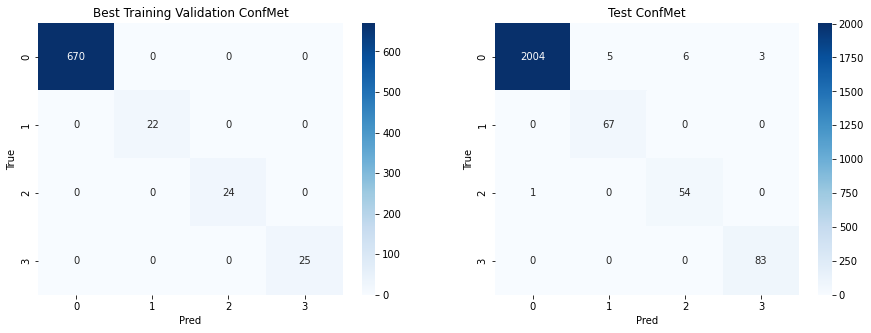

>>>> loop 1 : 




Epoch :: 100%|██████████| 8/8 [20:40<00:00, 155.08s/it]


,train_loss,val_loss,train_acc,val_acc
0,0.814995,0.753234,0.960714,0.998650
1,0.755822,0.749262,0.997451,0.995951
2,0.756431,0.806295,0.994452,0.925776
3,0.757940,0.807340,0.990103,0.943320
4,0.752674,0.748082,0.993852,0.995951
5,0.747752,0.744907,0.997001,0.998650
6,0.745037,0.743795,0.999250,1.000000
7,0.753658,0.767177,0.991303,0.975709



Training complete in 20m 41s
Best val Acc: 1.000000
================================== VALIDATING ==================================
Best Val Acc using sklearn:  1.0
 Val Precision : 1.0000 

 Val Recall : 1.0000 

 Val F1 Score : 1.0000 



Testing : 100%|██████████| 139/139 [00:16<00:00,  8.19it/s]


================================== TESTING ==================================

 Test Accuracy : 0.9960 
 Test Loss : 0.7472 

 Test Precision : 0.9962 

 Test Recall : 0.9960 

 Test F1 Score : 0.9960 



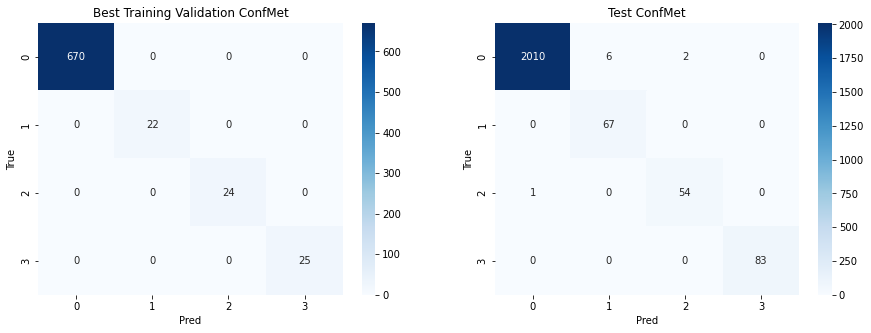

>>>> loop 2 : 




Epoch :: 100%|██████████| 8/8 [20:35<00:00, 154.50s/it]


,train_loss,val_loss,train_acc,val_acc
0,0.807005,0.770021,0.969711,0.993252
1,0.752465,0.810175,0.998351,0.986505
2,0.756759,0.747174,0.994452,0.997301
3,0.754915,0.743945,0.993102,1.000000
4,0.748555,0.771010,0.997151,0.967611
5,0.753640,0.765516,0.992053,0.986505
6,0.747448,0.744293,0.997451,1.000000
7,0.746041,0.745270,0.998800,0.998650



Training complete in 20m 36s
Best val Acc: 1.000000
================================== VALIDATING ==================================
Best Val Acc using sklearn:  1.0
 Val Precision : 1.0000 

 Val Recall : 1.0000 

 Val F1 Score : 1.0000 



Testing : 100%|██████████| 139/139 [00:16<00:00,  8.39it/s]


================================== TESTING ==================================

 Test Accuracy : 0.9969 
 Test Loss : 0.7469 

 Test Precision : 0.9970 

 Test Recall : 0.9969 

 Test F1 Score : 0.9969 



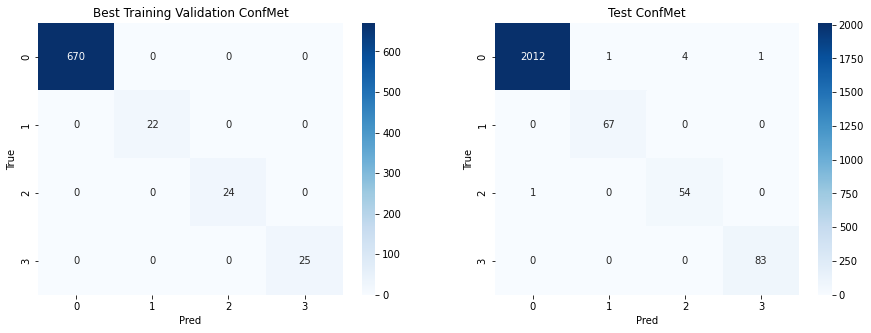

In [20]:
config36_acc_list, config36_loss_list, config36_f1_score_list, training_result, input_dict_test, trained_model_path = downstream_task(training_dataloader,
                                                                                                                                      test_dataloader,
                                                                                                                                      downstram_cls_len,
                                                                                                                                      epoch=8,
                                                                                                                                      pretrained_arch = True,
                                                                                                                                      mode = 'resnet50_config36')


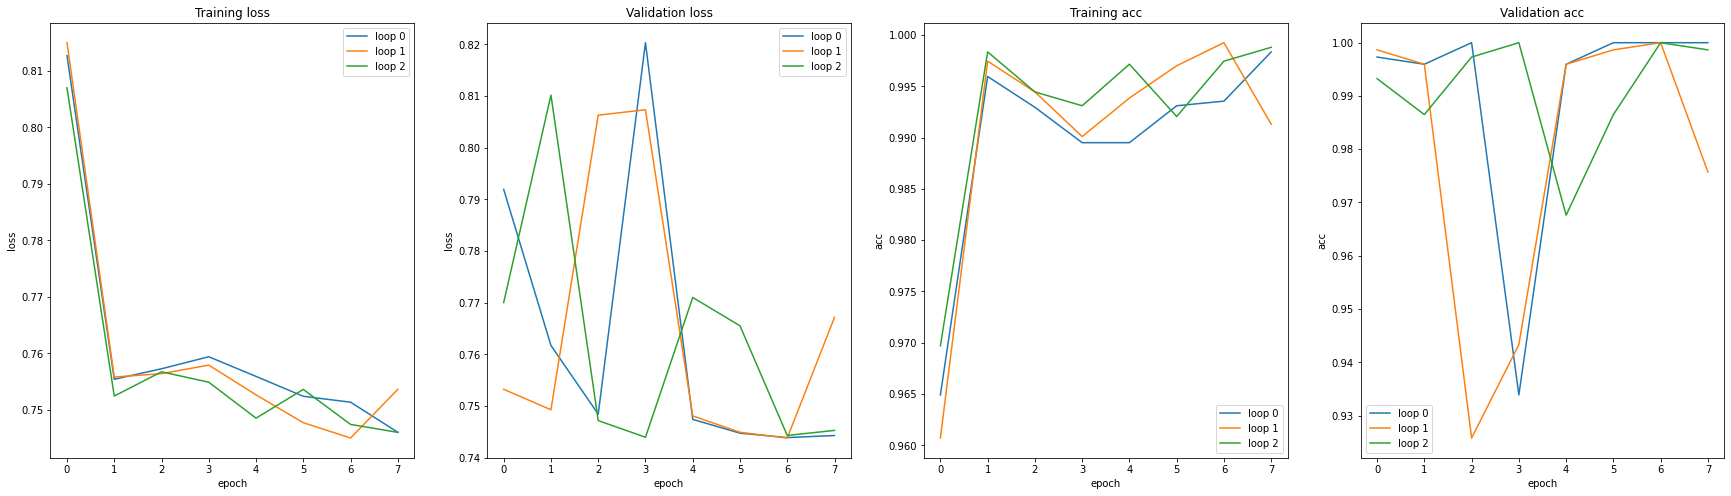

In [21]:
plot_training(training_result, 0.52, 1.15, 0.3, 1)

# **Result**

In [22]:
print("accuracy for 5 iteration:")
acc_df = pd.DataFrame({"accuracy_resnet50":config36_acc_list})
mean_acc=np.mean(config36_acc_list)
std_dev_acc = np.std(config36_acc_list)
mean_row = pd.DataFrame([str("avg = "+str(round(mean_acc,4))+' \u00B1 '+str(round(std_dev_acc,4)))],
                        columns=["accuracy_resnet50"])
acc_df = acc_df.append(mean_row)
acc_df.to_csv(path_result/"config36_acc_list.csv",index=False)
acc_df

accuracy for 5 iteration:


,accuracy_resnet50
0,0.993252
1,0.995951
2,0.996851
0,avg = 0.9954 ± 0.0015


In [23]:
print("F1 score for 5 iteration:")
fscore_df = pd.DataFrame({"F1_resnet50":config36_f1_score_list})
mean_fscore=np.mean(config36_f1_score_list)
std_dev_fscore = np.std(config36_f1_score_list)
mean_row = pd.DataFrame([str("avg = "+str(round(mean_fscore,4))+' \u00B1 '+str(round(std_dev_fscore,4)))],
                        columns=["F1_resnet50"])
fscore_df = fscore_df.append(mean_row)
fscore_df.to_csv(path_result/"config36_f1_score_list.csv",index=False)
fscore_df

F1 score for 5 iteration:


,F1_resnet50
0,0.993362
1,0.996012
2,0.996882
0,avg = 0.9954 ± 0.0015


In [24]:
print("loss for 5 iteration:")
loss_df = pd.DataFrame({"loss_resnet50":config36_loss_list})
mean_loss=np.mean(config36_loss_list)
std_dev_loss = np.std(config36_loss_list)
mean_row = pd.DataFrame([str("avg = "+str(round(mean_loss,4))+' \u00B1 '+str(round(std_dev_loss,4)))],
                        columns=["loss_resnet50"])
loss_df = loss_df.append(mean_row)
loss_df.to_csv(path_result/"config36_loss_list.csv",index=False)
loss_df

loss for 5 iteration:


,loss_resnet50
0,0.754393
1,0.747157
2,0.746867
0,avg = 0.7495 ± 0.0035


In [25]:
!nvidia-smi

Sun Nov  7 09:53:09 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P0    69W / 149W |   4535MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------